## Detector charachterization (Figure 3)

In [1]:
# Import modules
import sys, h5py
import numpy as np
%matplotlib notebook

# Ignore division warnings
s = np.seterr(divide='ignore', invalid='ignore')

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Gaussian model
gaussian = lambda x,A,mu,s: A * np.exp(-((mu-x)**2 /(2*s**2)))

In [3]:
# Pixel coordinates
bp = (8,238)
fp = (0,111)

In [4]:
# IO settings
plotdir = '/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/'

### 1. Loading data from file

In [5]:
# Data files (back)
back_signal_histfile    = '../meta/back/merged_histogram.h5'
back_signal_gainfile    = '../meta/back/gain/gainmap.h5'
back_signal_bgsigmafile = '../meta/back/gain/bg_sigmamap.h5'
back_signal_fittingfile = '../meta/back/gain/fitting_results.h5'
back_signal_maskfile    = '../meta/back/gain/included-pixels.h5'
back_geometryfile       = '../meta/back/back_geometry.h5'

# Data files (front)
front_signal_histfile    = '../meta/front/merged_histogram.h5'
front_signal_gainfile    = '../meta/front/gain/gainmap.h5'
front_signal_bgsigmafile = '../meta/front/gain/bg_sigmamap.h5'
front_signal_fittingfile = '../meta/front/gain/fitting_results.h5'
front_signal_maskfile    = '../meta/front/gain/included-pixels.h5'
front_geometryfile       = '../meta/front/front_geometry.h5'
front_bad_pixels_file    = '../meta/front/masks/front_bad-pixels.h5'

In [6]:
# Load histogram (back)
with h5py.File(back_signal_histfile, 'r') as f:
    back_ncount = float(f['data/histogramCount'][0])
    back_hist = f['data/histogram'][bp[0], bp[1]] / back_ncount
    hmin  = f['data/histogramMin'][:]
    hbins = f['data/histogramNbins'][:]
    hsize = f['data/histogramBinsize'][:]
    back_histbins = np.arange(hmin, hbins*hsize + hmin, hsize)

# Load gain map (back)
with h5py.File(back_signal_gainfile, 'r') as f:
    back_gainmap = f['data/data'][:]

# Load bg sigma map (back)
with h5py.File(back_signal_bgsigmafile, 'r') as f:
    back_bgsigma = f['data/data'][:]

# Load fitting results (back)
with h5py.File(back_signal_fittingfile, 'r') as f:
    back_photon_amp   = f['photon_amp'][:].reshape(back_gainmap.shape) / back_ncount
    back_photon_mu    = f['photon_offset'][:].reshape(back_gainmap.shape)
    back_photon_sigma = f['photon_sigma'][:].reshape(back_gainmap.shape)
    back_bg_amp   = f['bg_amp'][:].reshape(back_gainmap.shape) / back_ncount
    back_bg_mu    = f['bg_offset'][:].reshape(back_gainmap.shape)
    back_bg_sigma = f['bg_sigma'][:].reshape(back_gainmap.shape)

# Load mask from gain fitting (back)
with h5py.File(back_signal_maskfile, 'r') as f:
    back_gainmask = f['data/data'][:].astype(np.bool)

# Load geometry (back)
with h5py.File(back_geometryfile, 'r') as f:
    x = np.floor(f['x']).astype(np.int)
    y = np.floor(f['y']).astype(np.int)
    x -= x.min()
    y -= y.min()
    back_shape = (y.max() - y.min() + 1, x.max() - x.min() + 1)
    back_x, back_y = x,y

In [7]:
# Load histogram (front)
with h5py.File(front_signal_histfile, 'r') as f:
    front_ncount = float(f['data/histogramCount'][0])
    front_hist = f['data/histogram'][fp[0], fp[1]] / front_ncount
    hmin  = f['data/histogramMin'][:]
    hbins = f['data/histogramNbins'][:]
    hsize = f['data/histogramBinsize'][:]
    front_histbins = np.arange(hmin, hbins*hsize + hmin, hsize)

# Load gain map (front)
with h5py.File(front_signal_gainfile, 'r') as f:
    front_gainmap = f['data/data'][:]

# Load bg sigma map (front)
with h5py.File(front_signal_bgsigmafile, 'r') as f:
    front_bgsigma = f['data/data'][:]

# Load fitting results (front)
with h5py.File(front_signal_fittingfile, 'r') as f:
    front_photon_amp   = f['photon_amp'][:].reshape(front_gainmap.shape) / front_ncount
    front_photon_mu    = f['photon_offset'][:].reshape(front_gainmap.shape)
    front_photon_sigma = f['photon_sigma'][:].reshape(front_gainmap.shape)
    front_bg_amp   = f['bg_amp'][:].reshape(front_gainmap.shape) / front_ncount
    front_bg_mu    = f['bg_offset'][:].reshape(front_gainmap.shape)
    front_bg_sigma = f['bg_sigma'][:].reshape(front_gainmap.shape)

# Load mask from gain fitting (front)
with h5py.File(front_signal_maskfile, 'r') as f:
    front_gainmask = f['data/data'][:].astype(np.bool)
    
# Load bad-pixel mask (front)
with h5py.File(front_bad_pixels_file, 'r') as f:
    front_badpixels = f['data/data'][:].astype(np.bool)
front_gainmask &= front_badpixels   

# Load geometry (front)
with h5py.File(front_geometryfile, 'r') as f:
    x = np.floor(f['x'][:]/(110*1e-6)).astype(np.int)
    y = np.floor(f['y'][:]/(110*1e-6)).astype(np.int)
    x -= x.min()
    y -= y.min()
    front_shape = (y.max() - y.min() + 1, x.max() - x.min() + 1)
    front_x, front_y = x,y

### 2. Assemble maps and masks

In [8]:
def assemble(raw, shape, x, y):
    assembled = np.zeros(shape).astype(raw.dtype)
    assembled[y,x] = raw
    return assembled
c = 700

In [9]:
back_gainmap_a = assemble(back_gainmap, back_shape, back_x, back_y)
back_bgsigma_a = assemble(back_bgsigma, back_shape, back_x, back_y)
back_photon_amp_a = assemble(back_photon_amp, back_shape, back_x, back_y)
back_bg_amp_a = assemble(back_bg_amp, back_shape, back_x, back_y)
back_mask_a = assemble(back_gainmask, back_shape, back_x, back_y)
front_gainmap_a = np.rot90(assemble(front_gainmap, front_shape, front_x, front_y)[c:-c,c:-c], k=2)
front_bgsigma_a = np.rot90(assemble(front_bgsigma, front_shape, front_x, front_y)[c:-c,c:-c], k=2)
front_photon_amp_a = np.rot90(assemble(front_photon_amp, front_shape, front_x, front_y)[c:-c,c:-c], k=2)
front_bg_amp_a = np.rot90(assemble(front_bg_amp, front_shape, front_x, front_y)[c:-c,c:-c], k=2)
front_mask_a = np.rot90(assemble(front_gainmask, front_shape, front_x, front_y)[c:-c,c:-c], k=2)
front_badpix_a = np.rot90(assemble(front_badpixels, front_shape, front_x, front_y)[c:-c,c:-c], k=2)

### 3. Fit Gaussians

In [10]:
# Compute gaussians (back)
back_gauss_0 = gaussian(back_histbins, back_bg_amp[bp[0],bp[1]], back_bg_mu[bp[0], bp[1]], back_bg_sigma[bp[0],bp[1]])
back_gauss_1 = gaussian(back_histbins, back_photon_amp[bp[0], bp[1]], back_photon_mu[bp[0],bp[1]], back_photon_sigma[bp[0],bp[1]])

In [11]:
# Compute gaussians (front)
front_gauss_0 = gaussian(front_histbins, front_bg_amp[fp[0],fp[1]], front_bg_mu[fp[0], fp[1]], front_bg_sigma[fp[0],fp[1]])
front_gauss_1 = gaussian(front_histbins, front_photon_amp[fp[0], fp[1]], front_photon_mu[fp[0],fp[1]], front_photon_sigma[fp[0],fp[1]])

### 4. Define Signal-to-noise ratio

In [12]:
# Select good pixels
backselect = (back_gainmap[back_gainmask] > 18) & (back_gainmap[back_gainmask] < 33) & (back_bgsigma[back_gainmask] > 3.2) & (back_bgsigma[back_gainmask] < 5.2)
frontselect = (front_gainmap_a[front_mask_a] > 9) & (front_gainmap_a[front_mask_a] < 24) & (front_bgsigma_a[front_mask_a] > 2) & (front_bgsigma_a[front_mask_a] < 4)

# Map of Signal to noise
back_smap = back_gainmap[back_gainmask][backselect] / back_bgsigma[back_gainmask][backselect]
front_smap = front_gainmap_a[front_mask_a][frontselect] / front_bgsigma_a[front_mask_a][frontselect]

# Map of signal above noise (smap) for back
back_smap_a = back_gainmap_a / back_bgsigma_a
back_smap_hist, back_smap_bins = np.histogram(back_smap, range=(0,10), bins=200, density=True)

# Map of signal above noise (smap) for front
front_smap_a = (front_gainmap_a / front_bgsigma_a)
front_smap_hist, front_smap_bins = np.histogram(front_smap, range=(0,10), bins=200, density=True)

### 5. Plotting

<IPython.core.display.Javascript object>


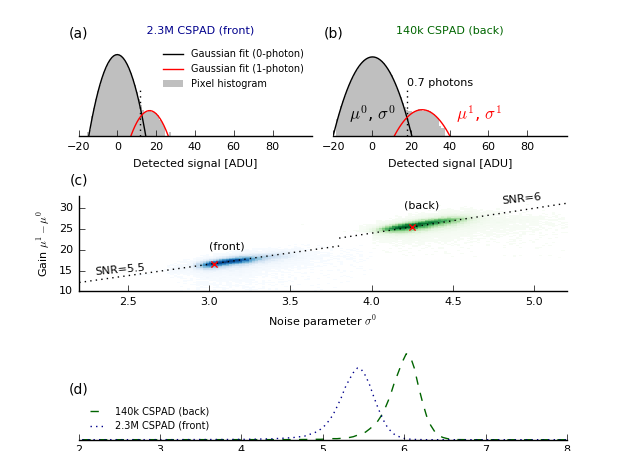

In [13]:
# Second idea for a plot
plot = plotting.Plot(rows=3, cols=4, exclude=range(16), border_in=.2,
                     fontsize=8, legend=True, legend_frameon=False, save_pdf=True)
plot.add_axes((0,2), 2,1, pady=0.09, hfrac=0.9)
plot.add_axes((2,2), 2,1, pady=0.09, hfrac=0.9)
plot.add_axes((0,1), 4,1, hfrac=0.9)
#plot.add_axes((2,1), 2,1, hfrac=0.9)
plot.add_axes((0,0), 4,1, pady=-0.075, hfrac=0.9)

plot.xlabel = ['Detected signal [ADU]', 
               'Detected signal [ADU]', 
               'Noise parameter $\sigma^{0}$', 
               #'Noise parameter $\sigma^{0}$',  
               r'Signal to noise ratio (SNR) $\mu^{1} - \mu^{0}$ / $\sigma^{0}$']
plot.ylabel = ['',#['Probability density', 
               '', 
               r'Gain $\mu^{1} - \mu^{0}$', 
               #'Gain $\mu^{1} - \mu^{0}$', 
               '']#'Probability density']
plot.title_label = ['   2.3M CSPAD (front)','140k CSPAD (back)', '', '', '']
plot.colorbar_label = r''

# Front detector
plot.plotting_a_histogram(0, front_hist[1:], front_histbins+0.5, type='bar', 
                          color=['0.75'], edgewidth=0, label=['Pixel histogram'])
plot.plotting_traces(0, 3*[front_histbins], [front_hist, front_gauss_0, front_gauss_1], 
                     ['', 'Gaussian fit (0-photon)', 'Gaussian fit (1-photon)'],
                     colors=['0.5', 'k', 'r'], linewidths=[0,1,1], logy=True, ylim=[1e-6,1])
plot.axes[0].axvline((front_photon_mu[fp[0], fp[1]] - front_bg_mu[fp[0], fp[1]])*0.7, ymax=0.5, color='k', ls=':')
plot.axes[0].set_yticklabels([])
plot.axes[0].set_xticks(range(-20,100,20))
plot.axes[0].text(-20,1, '(a)', fontsize=10, va='bottom', ha='center')
plot.axes[0].spines['top'].set_visible(False)
plot.axes[0].xaxis.set_ticks_position('bottom')
plot.axes[0].spines['left'].set_visible(False)
plot.axes[0].spines['right'].set_visible(False)
plot.axes[0].yaxis.set_ticks_position('none')
plot.axes[0].title.set_color('darkblue')

# Back detector
plot.plotting_a_histogram(1, back_hist[1:], back_histbins+0.5, type='bar', 
                          color=['0.75'], edgewidth=0, label=[''])
plot.plotting_traces(1, 3*[back_histbins],  [back_hist, back_gauss_0, back_gauss_1], 
                     3*[''],#['Pixel histogram', 'Gaussian fit (0-photon)', 'Gaussian fit (1-photon)'],
                     colors=['0.5', 'k', 'r'], linewidths=[0,1,1], logy=True, ylim=[1e-6,1])
plot.axes[1].axvline((back_photon_mu[bp[0], bp[1]] - back_bg_mu[bp[0], bp[1]])*0.7, ymax=0.5, color='k', ls=':')
plot.axes[1].text((back_photon_mu[bp[0], bp[1]] - back_bg_mu[bp[0], bp[1]])*0.7, 0.001, '0.7 photons', 
                  va='bottom', ha='left', fontsize=8)
plot.axes[1].set_xticks(range(-20,100,20))
plot.axes[1].text(0, 1e-5, r'$\mu^{0}$, $\sigma^{0}$', color='k', ha='center')
plot.axes[1].text(55,1e-5, r'$\mu^{1}$, $\sigma^{1}$', color='r', ha='center')
plot.axes[1].text(-20,1, '(b)', fontsize=10, va='bottom', ha='center')
plot.axes[1].spines['top'].set_visible(False)
plot.axes[1].xaxis.set_ticks_position('bottom')
plot.axes[1].spines['right'].set_visible(False)
plot.axes[1].spines['left'].set_visible(False)
plot.axes[1].yaxis.set_ticks_position('none')
plot.axes[1].set_yticklabels([])
plot.axes[1].title.set_color('darkgreen')


# Plot correlation
plot.legend_location = 4
plot.plotting_a_heatmap(2, back_bgsigma[back_gainmask], back_gainmap[back_gainmask], [[3.2,5.2],[18,33]], 
                        under='w', bins=100,alpha=1, cmaplist=['Greens'], zorder=0)
plot.plotting_traces(2, [np.linspace(3.8,5.2,100)], [6.*np.linspace(3.8,5.2,100)], [''], 
                     linestyles=[':'], colors=['k'], zorder=1)
plot.plotting_correlation(2, back_bgsigma[bp[0], bp[1]], back_gainmap[bp[0], bp[1]], color='r', 
                          ylim=[10,33], xlim=[2.2,5.5], zorder=2, marker='x', markersize=20)
plot.axes[2].text(2.2,35, '(c)', fontsize=10, va='bottom', ha='center')
plot.axes[2].spines['top'].set_visible(False)
plot.axes[2].xaxis.set_ticks_position('bottom')
plot.axes[2].spines['right'].set_visible(False)
plot.axes[2].yaxis.set_ticks_position('left')
plot.axes[2].text(2.3, 15, 'SNR=5.5', fontsize=8, rotation=5)
plot.axes[2].set_yticks([10,15,20,25,30])
plot.axes[2].set_xticks([2.5,3,3.5,4,4.5,5])
plot.axes[2].text(3,20, '(front)', fontsize=8)
plot.axes[2].text(4.2,30, '(back)', fontsize=8)

plot.plotting_a_heatmap(2, front_bgsigma_a[front_mask_a], front_gainmap_a[front_mask_a], [[2,4],[9,24]], 
                        under='w', bins=100,alpha=1, cmaplist=['Blues'], zorder=0)
plot.plotting_traces(2, [np.linspace(2,3.8,100)], [5.5*np.linspace(2,3.8,100)], [''], 
                     linestyles=[':'], colors=['k'], zorder=1)
plot.axes[2].text(4.8, 32, 'SNR=6', fontsize=8, rotation=6)

plot.plotting_correlation(2, front_bgsigma[fp[0], fp[1]], front_gainmap[fp[0], fp[1]], color='r', 
                          ylim=[10,33], xlim=[2.2,5.2], zorder=2, marker='x', markersize=20)

# Combined
plot.legend_location = 3
plot.plotting_a_histogram(3, back_smap_hist, back_smap_bins, type='line', color=['darkgreen'], linestyle='--', 
                          edgewidth=1, logy=False, ylim=[0,2.5], label=['140k CSPAD (back)'])
plot.plotting_a_histogram(3, front_smap_hist, front_smap_bins, type='line', color=['darkblue'], linestyle=':', 
                          edgewidth=1, logy=False, ylim=[0,2.5], label=['2.3M CSPAD (front)'])
plot.axes[3].text(2,1.5, '(d)', fontsize=10, va='top', ha='center')
plot.axes[3].spines['top'].set_visible(False)
plot.axes[3].spines['left'].set_visible(False)
plot.axes[3].spines['right'].set_visible(False)
plot.axes[3].yaxis.set_ticks_position('none')
plot.axes[3].set_yticklabels([])
plot.axes[3].set_xlim([2,8])

# Save plot to file                                                                                                                                                               
#plot.save(plotdir + 'fig_detectorchar.pdf')
plot.show()

**Figure 3.**
Pixel-wise characterization of the CSPAD detectors.                                                                           
(a)-(b) Normalized histograms (log scale) for two representative pixels integrated across all detected frames with Gaussian functions  
fitted to the 0- and 1-photon peaks. The black dotted lines correspond to the $0.7$ photon threshold used for counting.                
(c) 2D histograms of noise and gain estimates placed on grids of $100\times100$ pixels. The red crosses correspond                     
to the values of $\mu^{0}$, $\mu^{1}$ and $\sigma^{0}$ shown in the pixel histograms above. $97.4$\% (back) and $85.1$\% (front) of al\
l detector pixels                                                                                                                      
are represented, the rest are outliers due to misfitting.                                                                              
(d) Signal-to-noise ratio for all pixels shown as normalized histograms (linear scale).